In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from scipy.integrate import simpson


from scipy import stats

from multiprocessing import Pool, cpu_count
from conf_interval import conf_interval_calc



%load_ext autoreload
%autoreload 2

from pairedtest import pairedtest
# regex for number extraction from string
number_pattern =  r'(-?(?:0|[1-9]\d*)(?:\.\d+)?(?:[eE][+-]?\d+)?)'

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':200})

453
451
0.3637
0.3704
0.3706
0.3624
0.3733
----------------------------------------
0.3703
0.3707
0.3676
0.3694
0.3718


In [3]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [4]:
# res_df_list = [
#     pd.read_csv('./yeast_network_v_model.csv', index_col=0),
#     pd.read_csv('./bsubtilis_network_v_model.csv', index_col=0),
#     pd.read_csv('./arabidopsis_network_v_model.csv', index_col=0),
#     pd.read_csv('./mouse_bulk_network_v_model.csv', index_col=0)
# ]

tf_df_list = [
    pd.read_csv('../output/network_model/yeast_tf.csv', index_col=0, names=['tf']),
    pd.read_csv('../output/network_model/bsubtilis_tf.csv', index_col=0, names=['tf']),
    pd.read_csv('../output/network_model/arabidopsis_tf.csv', index_col=0, names=['tf']),
    pd.read_csv('../output/network_model/mouse_tf.csv', index_col=0, names=['tf']),
    pd.read_csv('../output/network_model/human_tf.csv', index_col=0, names=['tf']),
]

res_df_list = [
    pd.read_csv('../output/network_model/yeast_full_results.csv.gz', index_col=0, compression='gzip'),
    pd.read_csv('../output/network_model/bsubtilis_full_results.csv.gz', index_col=0, compression='gzip'),
    pd.read_csv('../output/network_model/arabidopsis_full_results.csv.gz', index_col=0, compression='gzip'),
    pd.read_csv('../output/network_model/mouse_full_results.csv.gz', index_col=0, compression='gzip'),
    pd.read_csv('../output/network_model/human_full_results.csv.gz', index_col=0, compression='gzip'),
]

species_names = ['Yeast', 'B.subtilis', 'Arabidopsis', 'Mouse', 'Human']
species_file_names = ['yeast', 'bsubtilis', 'arabidopsis', 'mouse', 'human']

filtered_df_list = [res_df[res_df['test_std'] > .5] for res_df in res_df_list]

compare_list = ['rf_rmse', 
                'linear_rmse', 
                'gs_rf_rmse', 
                'gs_linear_rmse', 
                'rf_top_tf_same_count_as_gs_rmse', 
                # 'linear_with_top_features_rmse', 
                'rf_efron_rmse']
                # 'linear_dynamic_efron_rmse']

compare_name_list = ['RF with all TFs',
                     'Linear with all TFs',
                     'RF with GS TFs',
                     'Linear with GS TFs',
                     'RF with top TFs',
                    #  'Linear with top TFs (95% top)',
                     'RF with Minimal TF set']
                    #  'Linear with top TFs (Efron)']



In [11]:
# Tables for pairwise comparisions between different regression approaches
compare_row_list = [r"\makecell{\color{blue}RF with \\ \color{blue}all TFs}",
 r'\makecell{\color{blue}Linear with \\ \color{blue}all TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}GS TFs}',
 r'\makecell{\color{blue}Linear with \\ \color{blue}GS TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}top TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}minimal TF set}']

for df, species_name in zip(res_df_list, species_names):
    print('Table content for {}: '.format(species_name))
    mean_row_list = ["Mean RMSE"]
    for model in compare_list:
        mean_row_list.append(f'{df[model].mean():.3f}')
    mean_row_list.append('\\\\ \\midrule')
    print(" & ".join(mean_row_list))

    for i in range(6):
        row_str_list = []
        row_str_list.append(compare_row_list[i])
        for j in range(6):
            if (j == i):
                row_str_list.append("-")
            else:
                t_res = stats.ttest_rel(df[compare_list[i]], df[compare_list[j]])
                non_parametric_res = pairedtest(df[compare_list[i]].values, df[compare_list[j]].values, 10000)
                prefix = ""
                if (t_res.statistic < 0) and (non_parametric_res < 0.05):
                    prefix = r"\color{blue}"
                elif (t_res.statistic > 0) and (non_parametric_res < 0.05):
                    prefix = r"\color{orange}"
                ci_res = t_res.confidence_interval()
                row_str_list.append(prefix + '('+f'{ci_res[0]:.3f}'+', '+f'{ci_res[1]:.3f}'+')')
        row_str_list.append('\\\\ \\midrule')
        row_str = " & ".join(row_str_list)
        print(row_str)
    print('----------------------------------------------------------------------------')
            

Table content for Yeast: 
Mean RMSE & 0.877 & 1.204 & 0.920 & 1.091 & 0.859 & 0.965 & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}all TFs} & - & \color{blue}(-0.397, -0.257) & \color{blue}(-0.055, -0.031) & \color{blue}(-0.263, -0.166) & \color{orange}(0.008, 0.027) & \color{blue}(-0.119, -0.058) & \\ \midrule
\makecell{\color{blue}Linear with \\ \color{blue}all TFs} & \color{orange}(0.257, 0.397) & - & \color{orange}(0.214, 0.354) & \color{orange}(0.047, 0.178) & \color{orange}(0.275, 0.414) & \color{orange}(0.169, 0.309) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}GS TFs} & \color{orange}(0.031, 0.055) & \color{blue}(-0.354, -0.214) & - & \color{blue}(-0.218, -0.124) & \color{orange}(0.046, 0.076) & \color{blue}(-0.075, -0.015) & \\ \midrule
\makecell{\color{blue}Linear with \\ \color{blue}GS TFs} & \color{orange}(0.166, 0.263) & \color{blue}(-0.178, -0.047) & \color{orange}(0.124, 0.218) & - & \color{orange}(0.185, 0.279) & \color{orange}(0.081, 0.172) & 

In [19]:
# Percentage of minimal sets that are smaller than 8 TFs
for df, species_name in zip(res_df_list, species_names):
    print(species_name+': ')
    minimal_set_sizes = []
    small_size_set = []
    for num_list, efron_size in zip(df['rf_efron_complementary_feature_num_list'], df['rf_efron_feature_num']):
        minimal_set_sizes.append(int(efron_size))
        if (int(efron_size) < 8):
            small_size_set.append(int(efron_size))
    print(1.0*len(small_size_set)/len(minimal_set_sizes))

Yeast: 
0.9662337662337662
B.subtilis: 
0.7353342428376535
Arabidopsis: 
0.9871152469577666
Mouse: 
0.7193548387096774
Human: 
0.9770773638968482


In [20]:
# Median and IQR for size of the minimal sets and GS 
for df, species_name in zip(res_df_list, species_names):
    print(species_name+': ')
    print('GS: {}[{}, {}]'.format(df['gs_edge_num'].quantile(.5), df['gs_edge_num'].quantile(.25), df['gs_edge_num'].quantile(.75)))
    print('Minimal Set {}[{}, {}]'.format(df['rf_efron_feature_num'].quantile(.5), df['rf_efron_feature_num'].quantile(.25), df['rf_efron_feature_num'].quantile(.75)))    

Yeast: 
GS: 51.0[41.0, 63.0]
Minimal Set 3.0[3.0, 3.0]
B.subtilis: 
GS: 1.0[1.0, 2.0]
Minimal Set 2.0[2.0, 9.0]
Arabidopsis: 
GS: 13.0[6.0, 19.0]
Minimal Set 3.0[3.0, 3.0]
Mouse: 
GS: 4.0[2.0, 7.0]
Minimal Set 5.0[2.0, 10.0]
Human: 
GS: 8.0[4.0, 14.0]
Minimal Set 3.0[3.0, 3.0]


In [24]:
# 
ensemble_compare_list = ['rf_rmse',  
                'gs_rf_rmse', 
                'rf_top_tf_same_count_as_gs_rmse', 
                'rf_efron_rmse']

ensemble_compare_row_list = [r"\makecell{\color{blue}RF with \\ \color{blue}all TFs}",
 r'\makecell{\color{blue}RF with \\ \color{blue}GS TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}top TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}minimal TF set}']

for i in range(4):
    row_str_list = []
    row_str_list.append(ensemble_compare_row_list[i])
    for df in res_df_list:
        ci_res = conf_interval_calc(df[compare_list[i]].values - df['rf_efron_ensemble_rmse'].values)
        mean_diff = (df[compare_list[i]] - df['rf_efron_ensemble_rmse']).mean()
        non_parametric_res = pairedtest(df[ensemble_compare_list[i]].values, df['rf_efron_ensemble_rmse'].values, 10000)
        prefix = ""
        if (mean_diff < 0) and (non_parametric_res < 0.05):
            prefix = r"\color{blue}"
        elif (mean_diff > 0) and (non_parametric_res < 0.05):
            prefix = r"\color{orange}"
        row_str_list.append(prefix + '('+f'{ci_res[2]:.3f}'+', '+f'{ci_res[3]:.3f}'+')')
    row_str_list.append('\\\\ \\midrule')
    row_str = " & ".join(row_str_list)
    print(row_str)


\makecell{\color{blue}RF with \\ \color{blue}all TFs} & \color{blue}(-0.058, -0.017) & (-0.009, 0.008) & (-0.009, 0.001) & (-0.038, 0.013) & \color{blue}(-0.021, -0.003) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}GS TFs} & (0.227, 0.366) & \color{orange}(-0.003, 0.034) & \color{orange}(0.270, 0.349) & \color{orange}(0.034, 0.223) & \color{orange}(0.115, 0.181) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}top TFs} & \color{orange}(-0.010, 0.027) & \color{orange}(0.122, 0.170) & \color{orange}(0.090, 0.133) & \color{orange}(0.169, 0.444) & \color{orange}(0.085, 0.134) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}minimal TF set} & \color{orange}(0.138, 0.231) & \color{orange}(0.196, 0.249) & \color{orange}(0.105, 0.146) & \color{orange}(0.350, 0.681) & \color{orange}(0.464, 0.610) & \\ \midrule


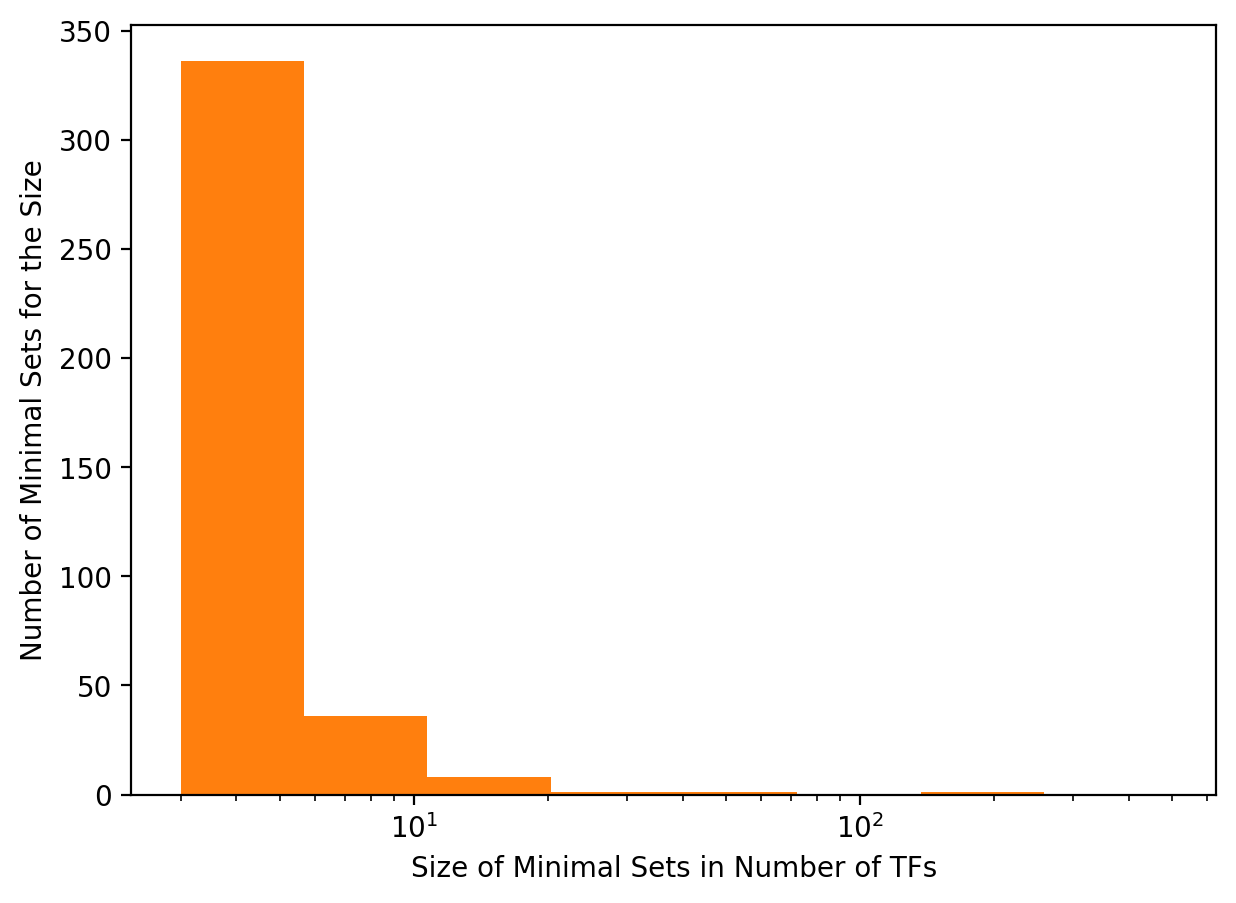

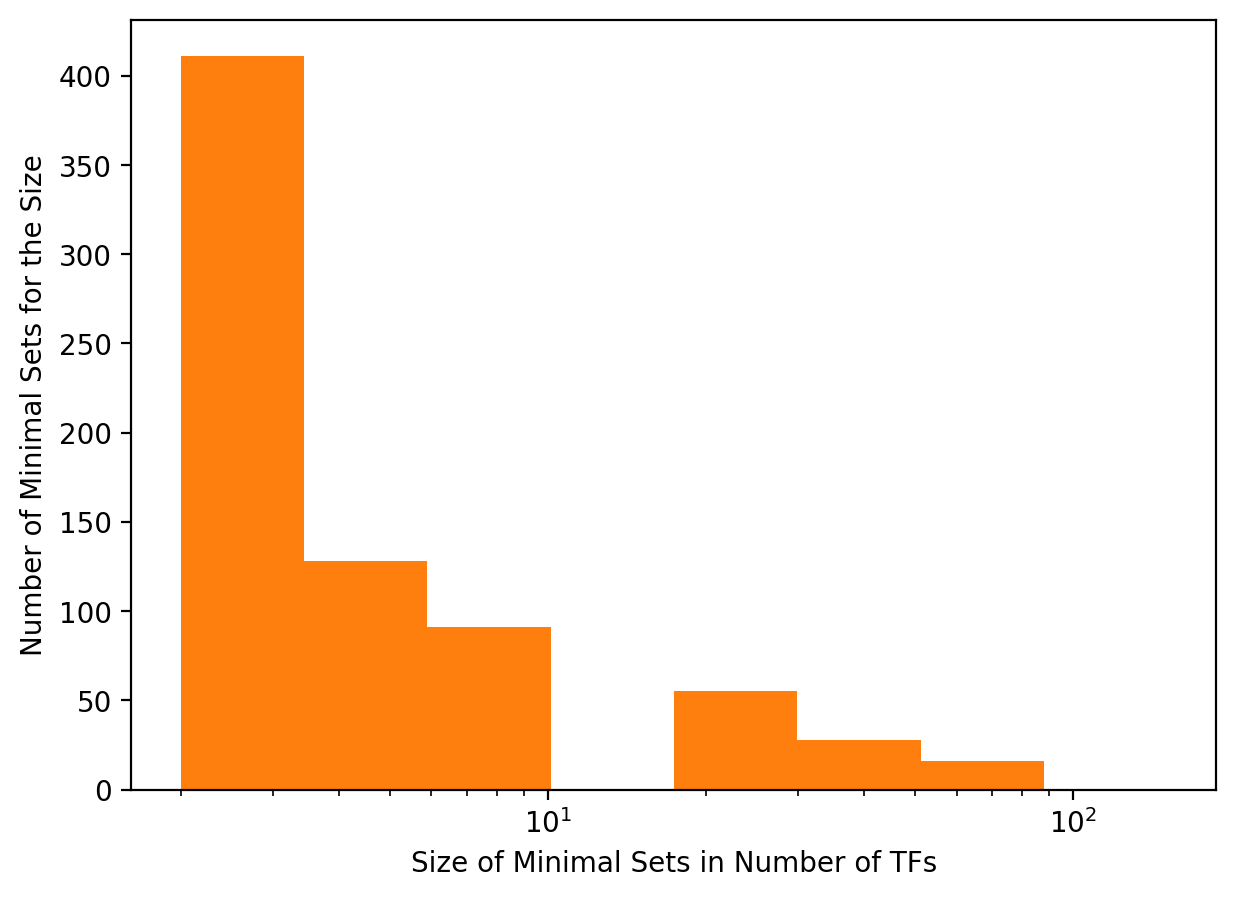

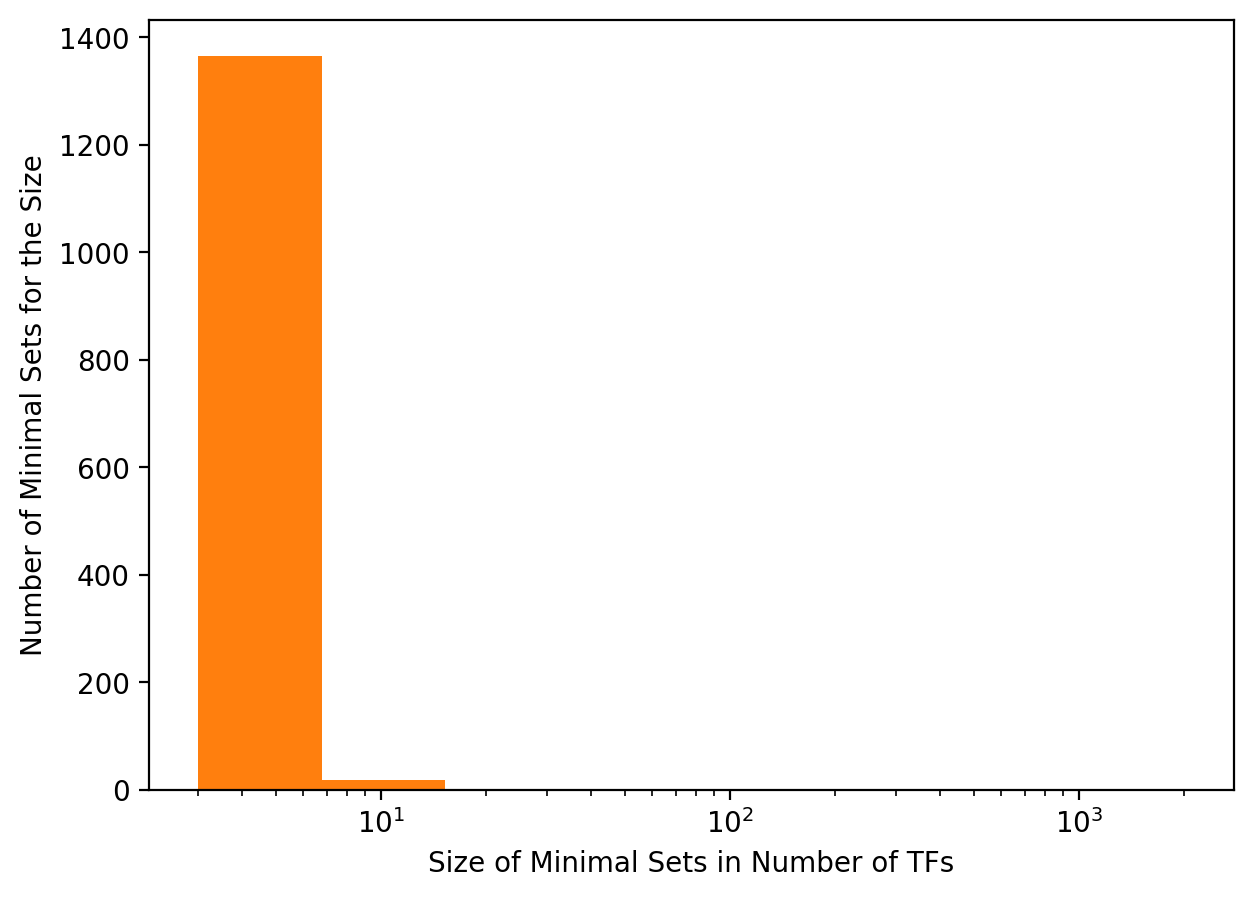

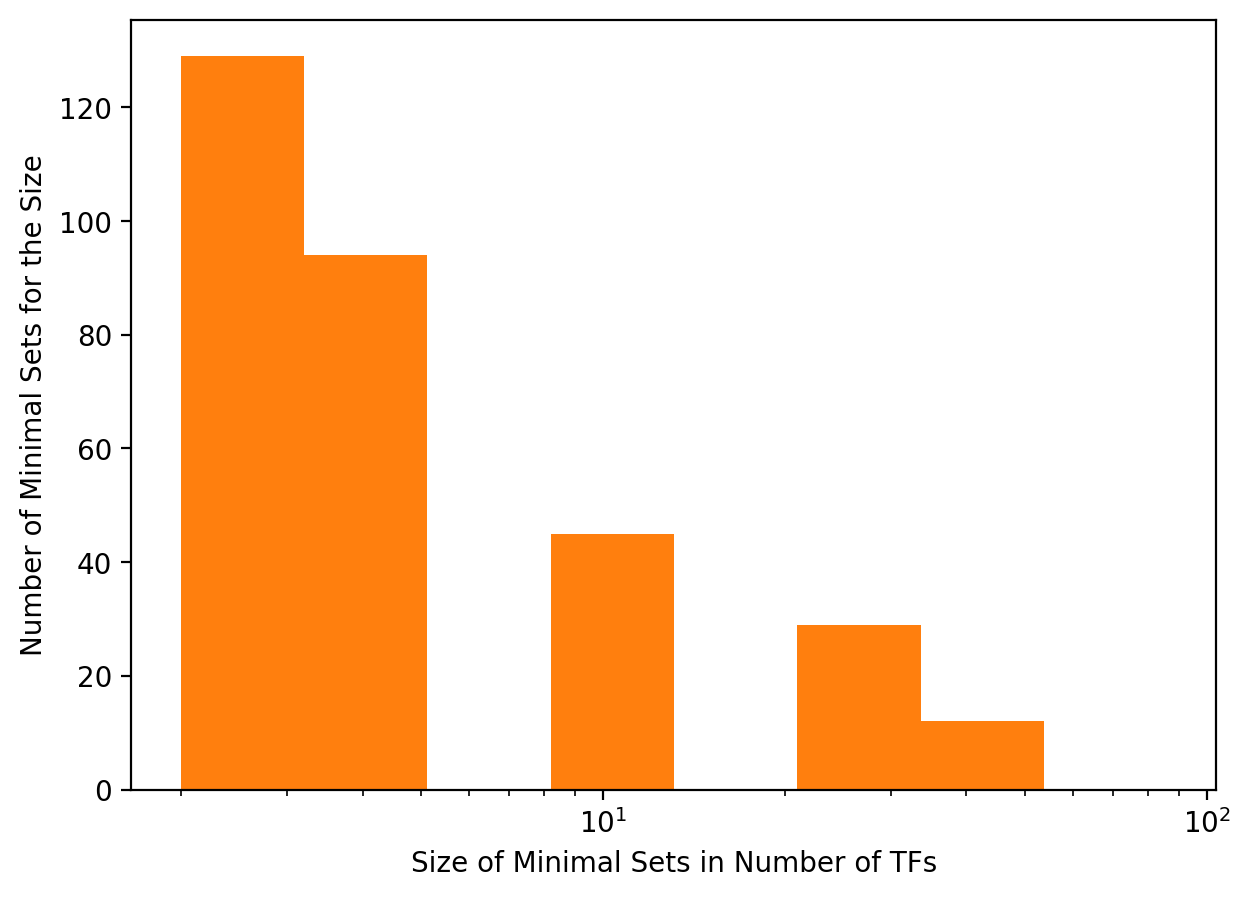

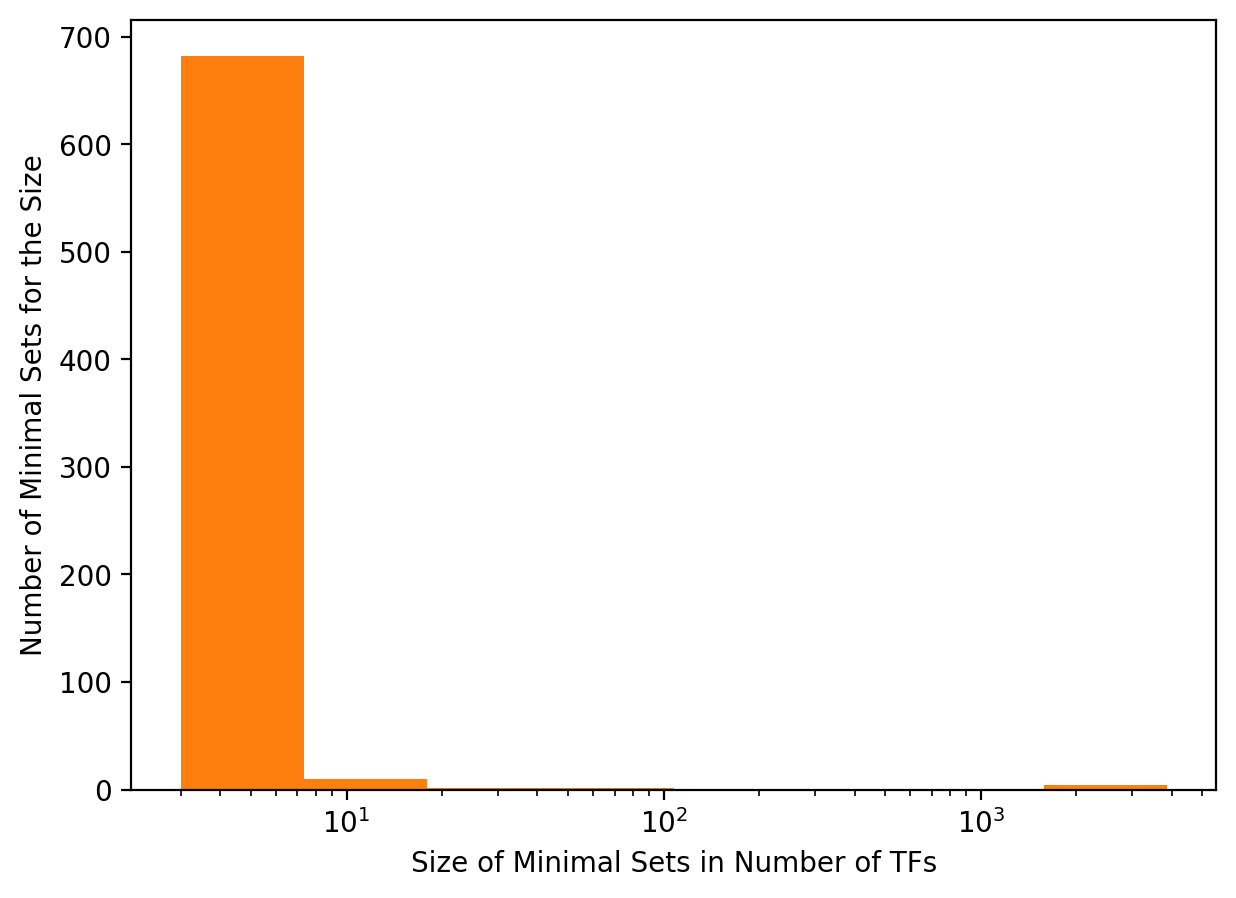

In [37]:
# Minimal set size distribution plot
for df, species_name in zip(res_df_list, species_file_names):
    minimal_set_sizes = []
    for num_list, efron_size in zip(df['rf_efron_complementary_feature_num_list'], df['rf_efron_feature_num']):
        minimal_set_sizes.append(int(efron_size))
    hist, bins = np.histogram(minimal_set_sizes, bins=8)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(minimal_set_sizes, bins=logbins, color=colors[1])
    ax.set_xscale('log')
    ax.set(xlabel='Size of Minimal Sets in Number of TFs')
    ax.set(ylabel='Number of Minimal Sets for the Size')
    # plt.title('Model Performance on '+ species_name +' Target Genes')
    # plt.legend()
    plt.savefig('./plot_output/minimal_sets_size/'+species_name+'.pdf', bbox_inches='tight')

For yeast, percentage of target genes with less than 5 disjoint sets: 
0.44155844155844154
For bsubtilis, percentage of target genes with less than 5 disjoint sets: 
0.4406548431105048
For arabidopsis, percentage of target genes with less than 5 disjoint sets: 
0.15246957766642805
For mouse, percentage of target genes with less than 5 disjoint sets: 
0.25483870967741934
For human, percentage of target genes with less than 5 disjoint sets: 
0.10315186246418338


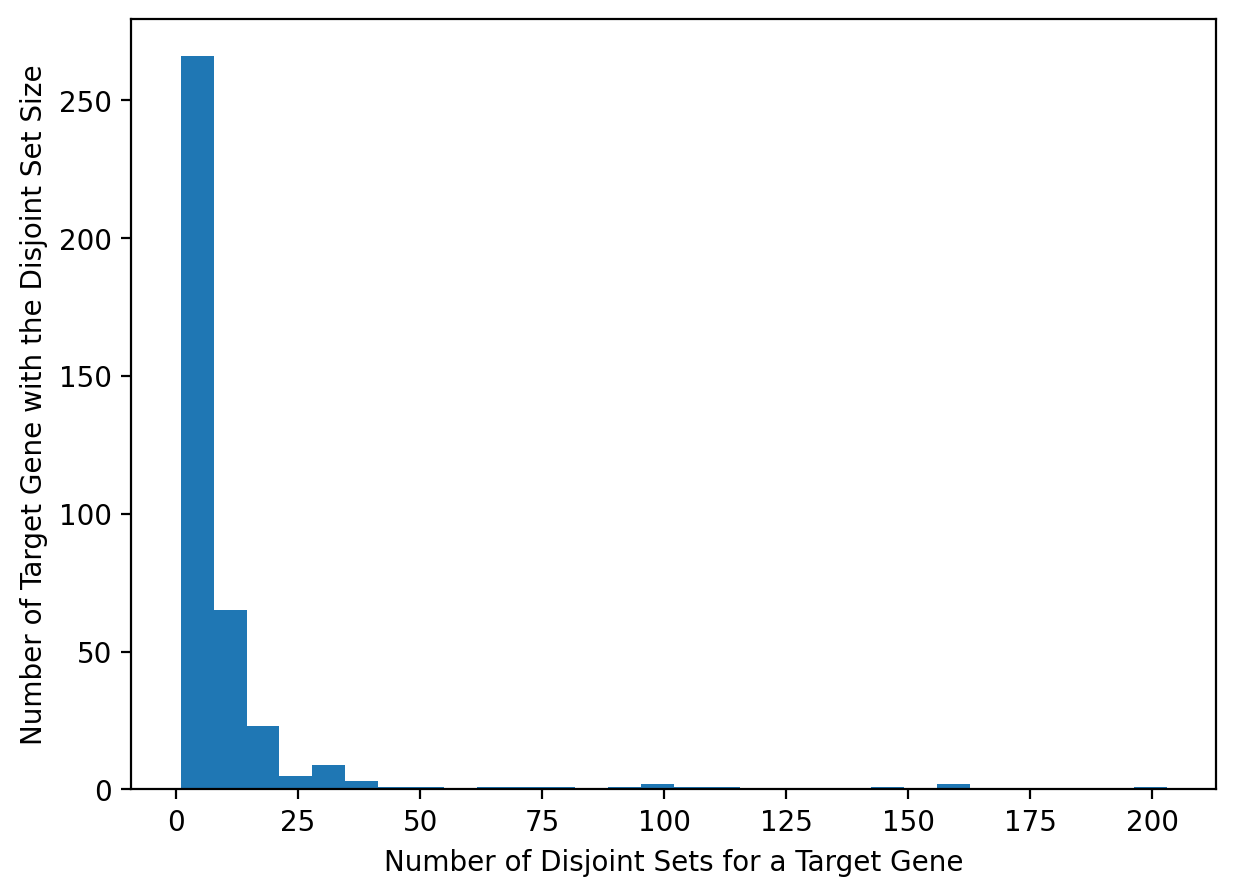

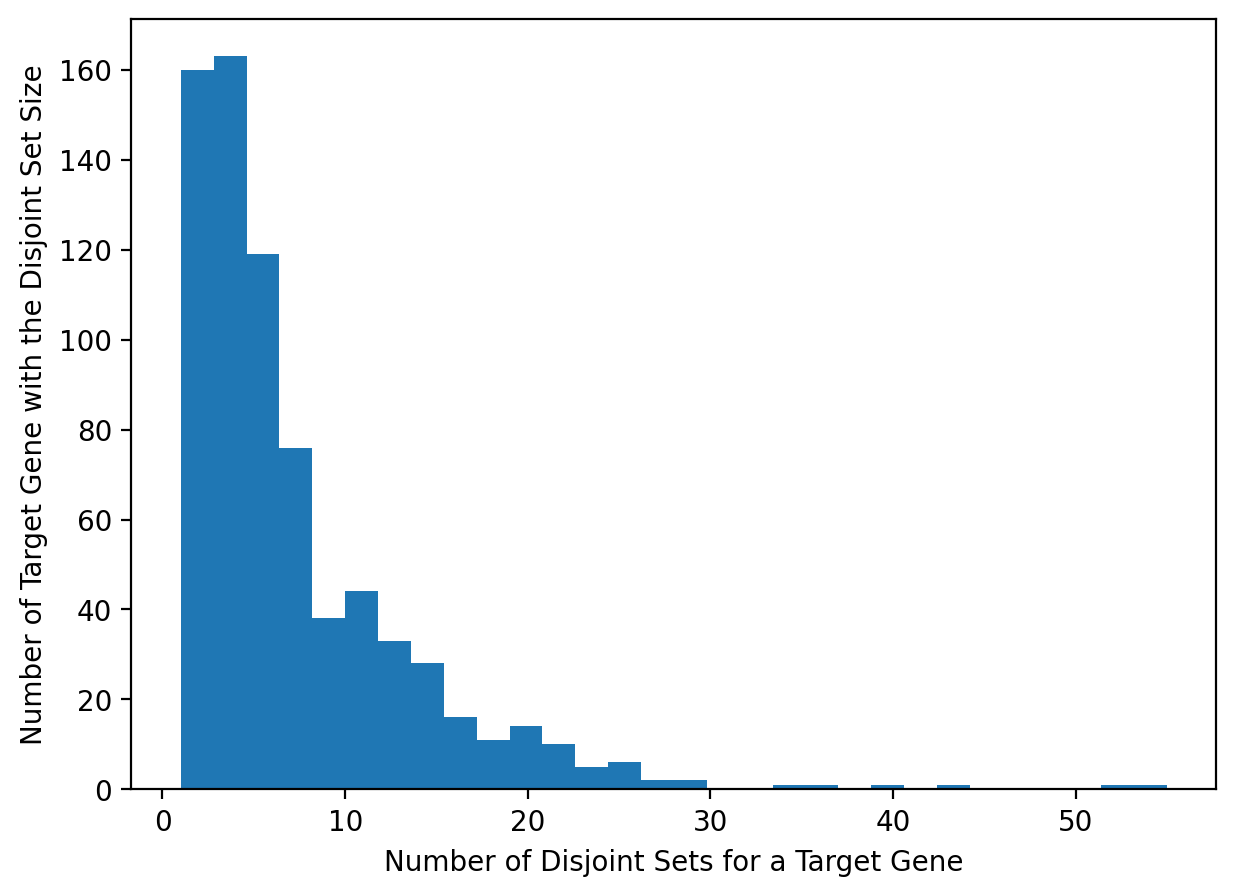

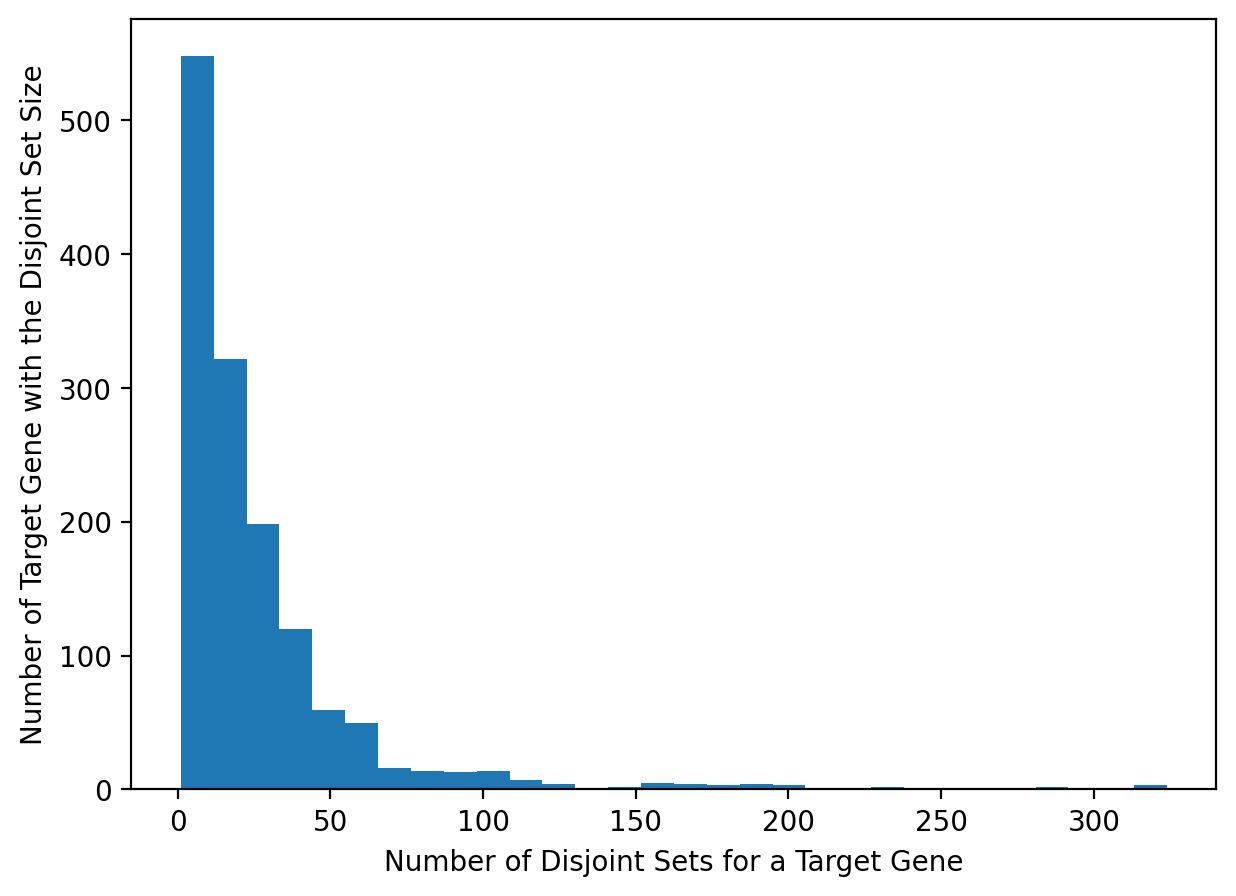

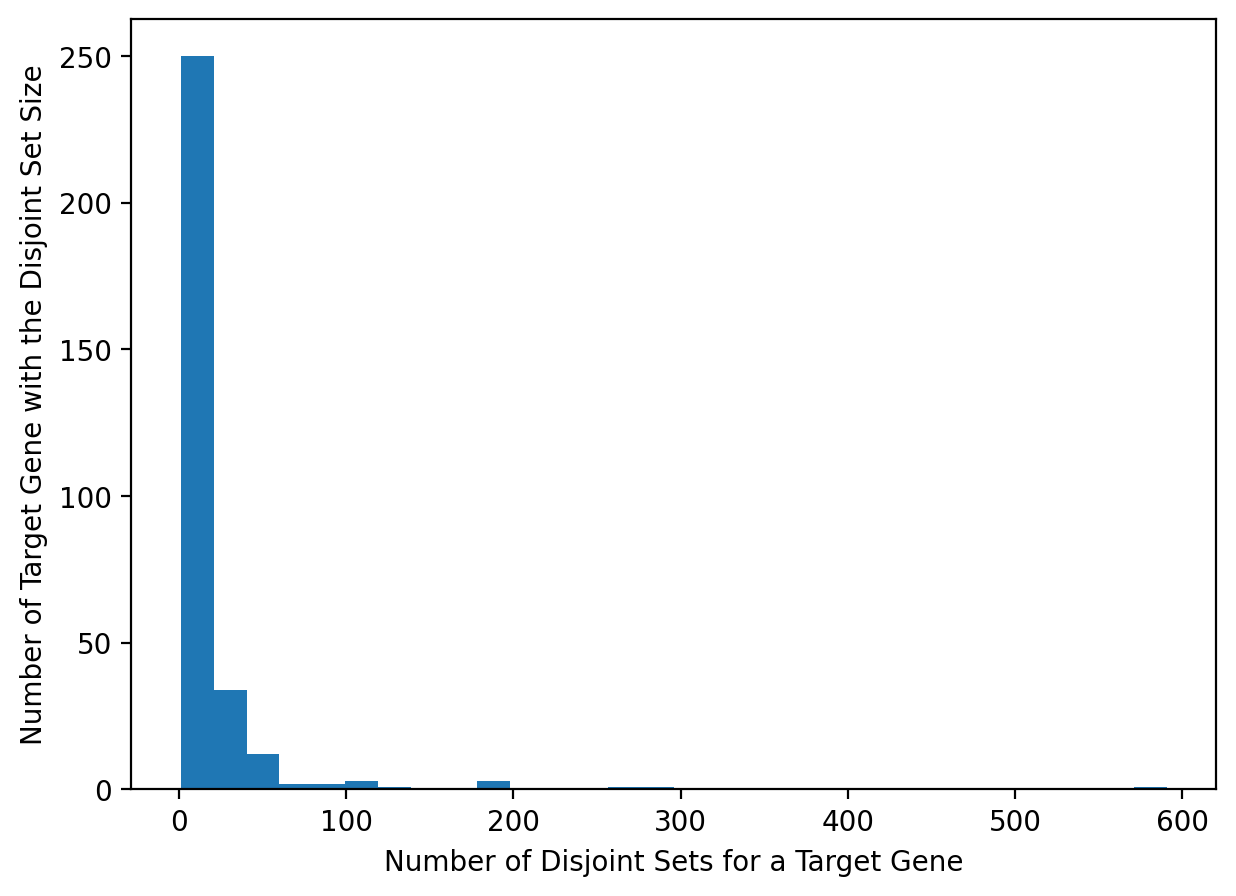

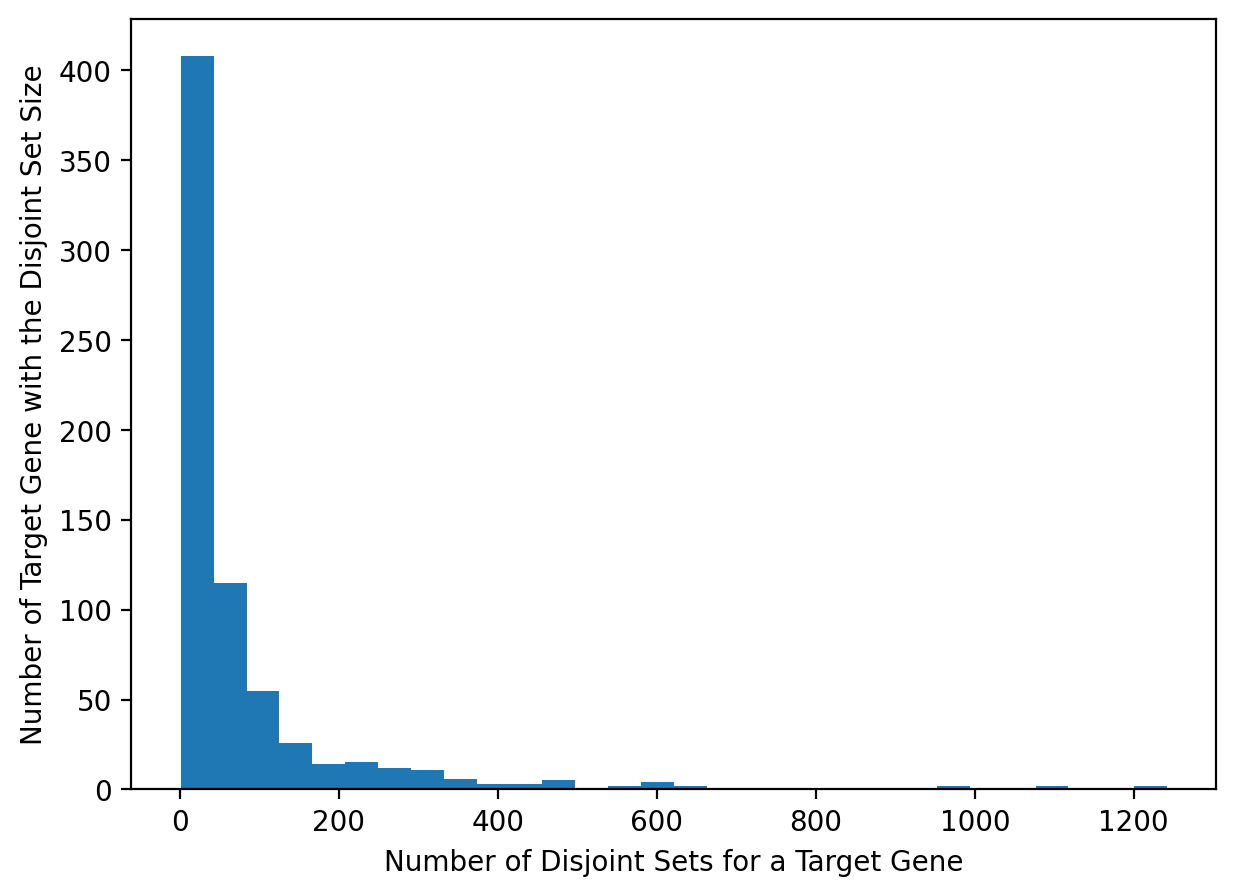

In [38]:
for df, species_name in zip(res_df_list, species_file_names):
    disjoint_set_count = []
    for num_list in df['rf_efron_complementary_feature_num_list']:
        if isinstance(num_list, str):
            disjoint_set_count.append(len(num_list.split(', '))+1)
        else:
            disjoint_set_count.append(1)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(disjoint_set_count, bins=30)
    ax.set(xlabel='Number of Disjoint Sets for a Target Gene')
    ax.set(ylabel='Number of Target Gene with the Disjoint Set Size')
    # plt.title('Model Performance on '+ species_name +' Target Genes')
    print('For {}, percentage of target genes with less than 5 disjoint sets: '.format(species_name))
    print(1.0*sum(i < 5 for i in disjoint_set_count)/len(disjoint_set_count))
    # plt.legend()
    plt.savefig('./plot_output/disjoint_sets_count/'+species_name+'.pdf', bbox_inches='tight')

In [113]:
# Find examples for disjoint set overlap examples
def find(index, name, common_set_size, early_stop=True):
    print('{}: '.format(name))
    test_df = res_df_list[index]
    df_length = len(test_df)
    tf_df = tf_df_list[index]
    disjoint_set_dict = {}
    disjoint_set_dict_by_name = {}
    for i in range(df_length):
        i_sets = []
        i_sets.append(set([int(idx) for idx in test_df.iloc[i]['rf_efron_features'].split('; ')]))
        complementary_sets = test_df.iloc[i]['rf_efron_complementary_features_list']
        if isinstance(complementary_sets, str):
            complementary_sets = complementary_sets.split(', ')
            complementary_sets = [set([int(idx) for idx in s.split('; ')]) for s in complementary_sets]
            i_sets.extend(complementary_sets)
        
        disjoint_set_dict[i] = []
        disjoint_set_dict_by_name[test_df.index[i]] = []
        for s in i_sets:
            if len(s) < 5:
                disjoint_set_dict[i].append(s)
                disjoint_set_dict_by_name[test_df.index[i]].append(tf_df.index[list(s)])
    for i in tqdm(range(df_length)):
        should_continue = True
        if (len(disjoint_set_dict[i]) < 3):
            continue
        for j in range(i+1, df_length):
            if (len(disjoint_set_dict[j]) < 3):
                continue
            for set_m in disjoint_set_dict[i]:
                for set_n in disjoint_set_dict[j]:
                    if (set_m == set_n) and (len(set_m) == common_set_size):
                        print('Common disjoint set:')
                        print(tf_df.index[list(set_n)].values)
                        print('Disjoint sets of target gene {}:'.format(test_df.index[i]))
                        for s in disjoint_set_dict[i]:
                            print(tf_df.index[list(s)].values)
                        print('Disjoint sets of target gene {}:'.format(test_df.index[j]))
                        for s in disjoint_set_dict[j]:
                            print(tf_df.index[list(s)].values)
                        print('---------------------------------------------')
                        # return 0
                        should_continue = False
            if not should_continue and early_stop: break
        if not should_continue and early_stop: break

In [114]:
find(0, 'Yeast', 3)

Yeast: 


  2%|▏         | 7/385 [00:00<00:00, 5639.67it/s]

Common disjoint set:
['YHL027W' 'YBR244W' 'YBL016W']
Disjoint sets of target gene YHR005C-A:
['YHL027W' 'YBR244W' 'YBL016W']
['YOR059C' 'YHR143W-A' 'YLL051C']
['YBR278W' 'YDR335W' 'YLR256W']
Disjoint sets of target gene YBR181C:
['YHL027W' 'YBR244W' 'YBL016W']
['YOR059C' 'YHR143W-A' 'YNL239W']
['YLL051C' 'YOL128C' 'YDR216W']
['YGL038C' 'YLR220W' 'YDR034C']
['YOR230W' 'YHR071W' 'YGL073W']
['YBR278W' 'YDR335W' 'YDL190C']
---------------------------------------------


In [115]:
find(1, 'B.subtilis', 3)

B.subtilis: 


  1%|          | 8/733 [00:00<00:00, 1000.28it/s]

Common disjoint set:
['mhqR' 'tilS' 'sigD']
Disjoint sets of target gene ptsG:
['ccpA' 'liaR']
['lexA' 'sigL' 'glnL' 'licT']
['malR' 'gutR']
['yfhP' 'codY']
['purR' 'mtlR']
['comA' 'iolR' 'ccpN' 'walR']
['araR' 'cysL']
['birA' 'hprT' 'deoR' 'comK']
['xre' 'dnaA']
['tilS' 'mhqR' 'sigD']
['fruR' 'yxdJ' 'resD']
['ansR' 'sigO' 'glcT']
Disjoint sets of target gene ftsH:
['glcR' 'codY']
['ccpC' 'gutR']
['araR' 'liaR']
['nusA' 'comK']
['yfmP' 'nrdR' 'licR']
['birA' 'malR' 'ansR']
['cysL' 'sigF' 'mtlR']
['hprT' 'deoR' 'gltC']
['comA' 'treR' 'zur']
['mhqR' 'tilS' 'sigD']
['fruR' 'bltR']
['mdxR' 'frlR' 'sigH' 'yrkP']
['arsR' 'rpmE' 'natR' 'sigY']
---------------------------------------------


In [116]:
find(2, 'Arabidopsis', 3)

Arabidopsis: 


  0%|          | 4/1397 [00:00<00:17, 78.09it/s]

Common disjoint set:
['AT1G10170' 'AT3G27260' 'AT3G04930']
Disjoint sets of target gene AT3G55440:
['AT1G10170' 'AT3G27260' 'AT3G04930']
['AT4G16110' 'AT5G67300' 'AT5G51190']
['AT2G35940' 'AT1G72010' 'AT3G10490']
['AT5G06510' 'AT2G41180' 'AT3G24240']
['AT3G60320' 'AT4G10710' 'AT4G23810']
['AT1G14920' 'AT1G25560' 'AT3G61630']
['AT4G08920' 'AT2G20570' 'AT5G48940']
['AT2G41940' 'AT1G74560' 'AT1G66390']
['AT1G25440' 'AT5G22250' 'AT3G15030']
['AT5G52310' 'AT1G51700' 'AT5G17050']
['AT3G56710' 'AT2G04880' 'AT5G39760']
['AT2G18328' 'AT3G21270' 'AT5G28040']
Disjoint sets of target gene AT1G70850:
['AT1G10170' 'AT3G27260' 'AT3G04930']
['AT4G16110' 'AT4G23810' 'AT5G51190']
['AT5G57660' 'AT1G72010' 'AT3G24240']
['AT4G10710' 'AT5G06510' 'AT1G74560']
['AT1G14920' 'AT1G51950' 'AT5G67300']
['AT5G52310' 'AT1G50420' 'AT3G43190']
['AT1G68360' 'AT1G13260' 'AT1G07530']
['AT2G24790' 'AT1G28520' 'AT2G38560']
['AT3G58710' 'AT3G10490' 'AT4G12080']
['AT1G25440' 'AT2G35940' 'AT2G40950']
['AT5G09870' 'AT2G27050' 

In [117]:
find(3, 'Mouse', 2, False)

Mouse: 


100%|██████████| 310/310 [00:00<00:00, 2143.30it/s]

Common disjoint set:
['Irf1' 'H3f3b']
Disjoint sets of target gene Cxcl10:
['Irf1' 'H3f3b']
['Nfkbia' 'Klf6']
['Jun' 'Tnfaip3']
['Mdm2' 'Junb']
Disjoint sets of target gene Stat1:
['Irf1' 'H3f3b']
['Tgif1' 'Tnfaip3']
['Zfp768' 'Klf6']
['Cflar' 'Sf1']
['Zfp36' 'Reep6']
['Lmo4' 'Nfkb2']
---------------------------------------------
Common disjoint set:
['Irf1' 'H3f3b']
Disjoint sets of target gene Cxcl10:
['Irf1' 'H3f3b']
['Nfkbia' 'Klf6']
['Jun' 'Tnfaip3']
['Mdm2' 'Junb']
Disjoint sets of target gene Psmb9:
['Irf1' 'H3f3b']
['Cdkn1a' 'Sdcbp']
['Sf1' 'Mxd1']
['Nfkb2' 'Sumo1']
---------------------------------------------
Common disjoint set:
['Foxa3' 'Gatad1']
Disjoint sets of target gene Mif:
['Foxa3' 'Gatad1']
['Fam210b' 'Ubb']
['Gstm7' 'Ifrd1']
['Nr1h3' 'Gtf2f1']
['Hexim1' 'Rbpj']
['Maz' 'Phc2']
['Trp53' 'Agap3']
['Gatad2a' 'Cic']
['Khdrbs1' 'Fbl']
['Prkcb' 'Mdfic']
['Setd3' 'Sash3']
['Cdk10' 'Smad4' 'Nfkb2' 'Baz1b']
['Atxn7l3' 'Crtc2' 'Lrrfip1' 'Ripk1']
['Kat5' 'Gbp2' 'Dhx9' 'Zbtb7b'

In [119]:
find(4, 'human', 3)

human: 


  4%|▍         | 30/698 [00:01<00:26, 25.31it/s]

Common disjoint set:
['SCML2' 'NFIC' 'ELAVL2']
Disjoint sets of target gene UBC:
['ANP32B' 'NCBP2' 'ZNF789']
['NEDD4' 'SMAD2' 'DLL4']
['FOXN2' 'ZKSCAN8' 'ARID2']
['ASH1L' 'ZNF273' 'CEP162']
['SCML2' 'NFIC' 'ELAVL2']
['NKX2-1' 'ZEB1' 'MAPK8IP1']
['TRBC2' 'CDX1' 'TTC5']
['NCBP1' 'SIK1' 'CMKLR1']
['DYRK2' 'BCL6B' 'SNURF']
['TBX3' 'CTDSPL' 'ZNF362']
['RBP2' 'JMY' 'LIMD1']
['SP1' 'ZNF581' 'TRIM16']
['ZFP82' 'FBXW7' 'RBL1']
['GCN1' 'MDM4' 'PTK6']
['ZBTB41' 'SHANK1' 'DLX4']
['SCAND1' 'HSFX3' 'TFPT']
['KDM3A' 'RORB' 'ZNF354B']
['ZNF584' 'SRFBP1' 'RBFOX2']
['ISG15' 'IKZF5' 'SMARCB1']
['MIF' 'RNF10' 'SNW1']
['NME2' 'SOST' 'METTL21A']
['ADD1' 'TCF4' 'IL1B']
['PPFIA1' 'BBS4' 'HOXD3']
['NFXL1' 'XCL1' 'COPS3']
['FUBP1' 'HDAC4' 'ZNF215']
['FUBP3' 'KAZN' 'CAMK2A']
['ATF7IP' 'NFYB' 'PAX8']
Disjoint sets of target gene SET:
['ZNF584' 'HOXD3' 'BAG3']
['PRMT1' 'SHANK1' 'NF2']
['SRFBP1' 'TRAV12-1' 'PTK6']
['TCF4' 'SUMO1' 'IFNB1']
['KDM3A' 'UCP1' 'CDX1']
['HSFX3' 'RBL1' 'MAPK8IP1']
['DLL4' 'IRF2BP1' 'TFPT']

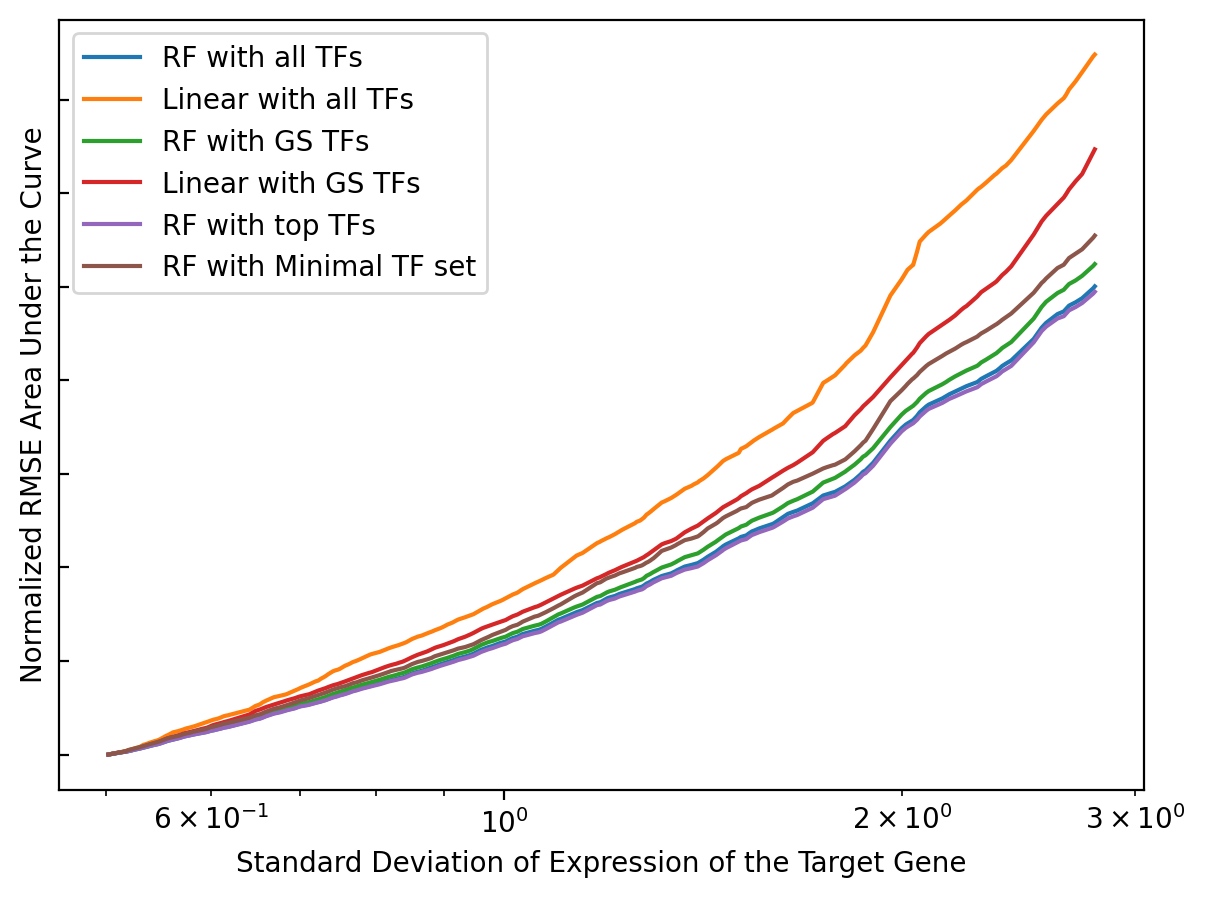

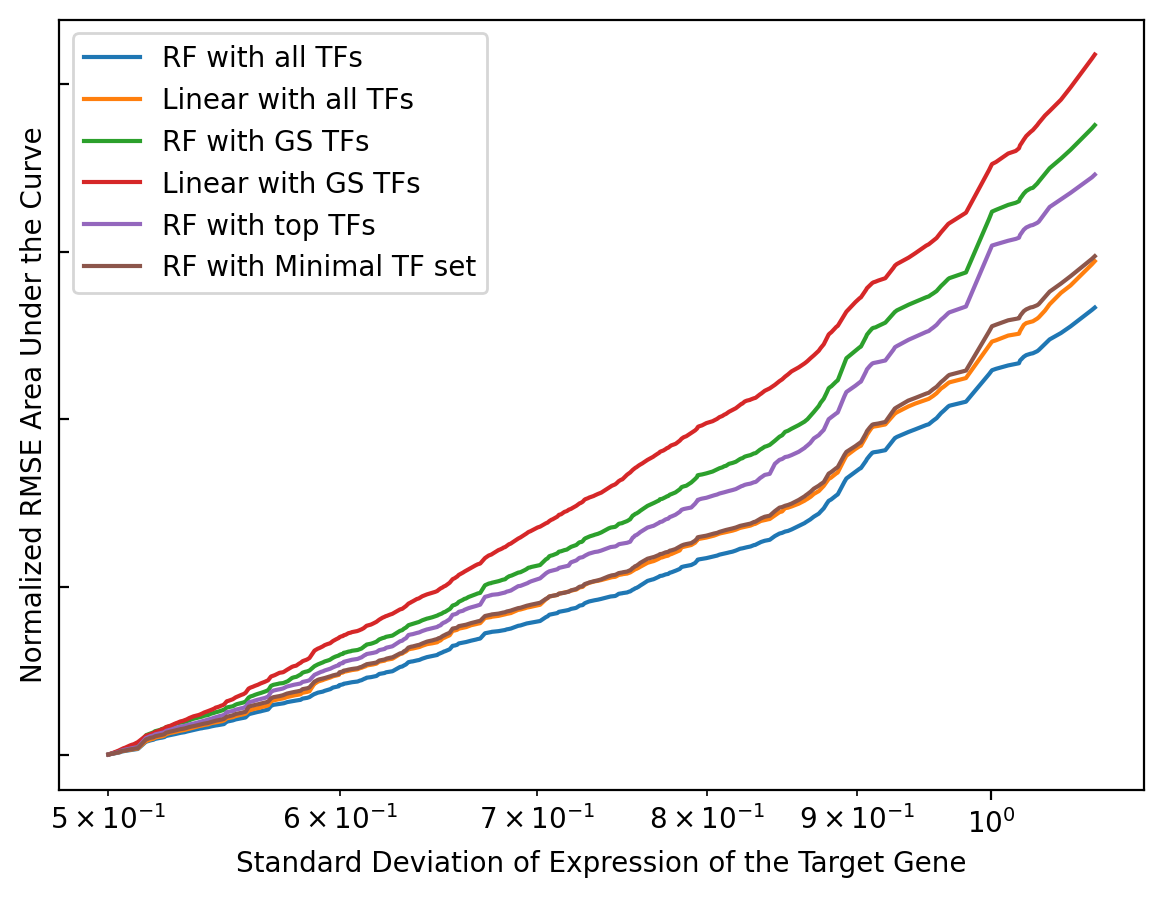

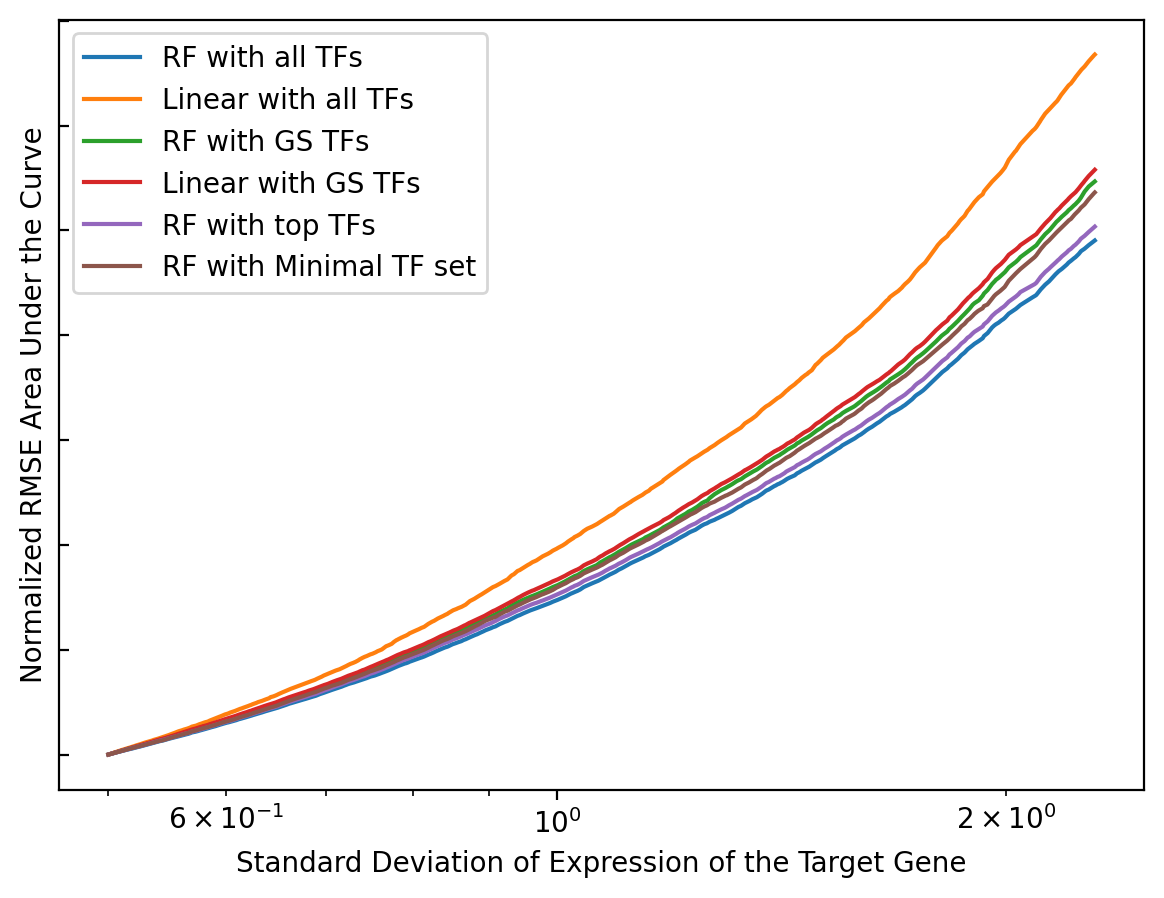

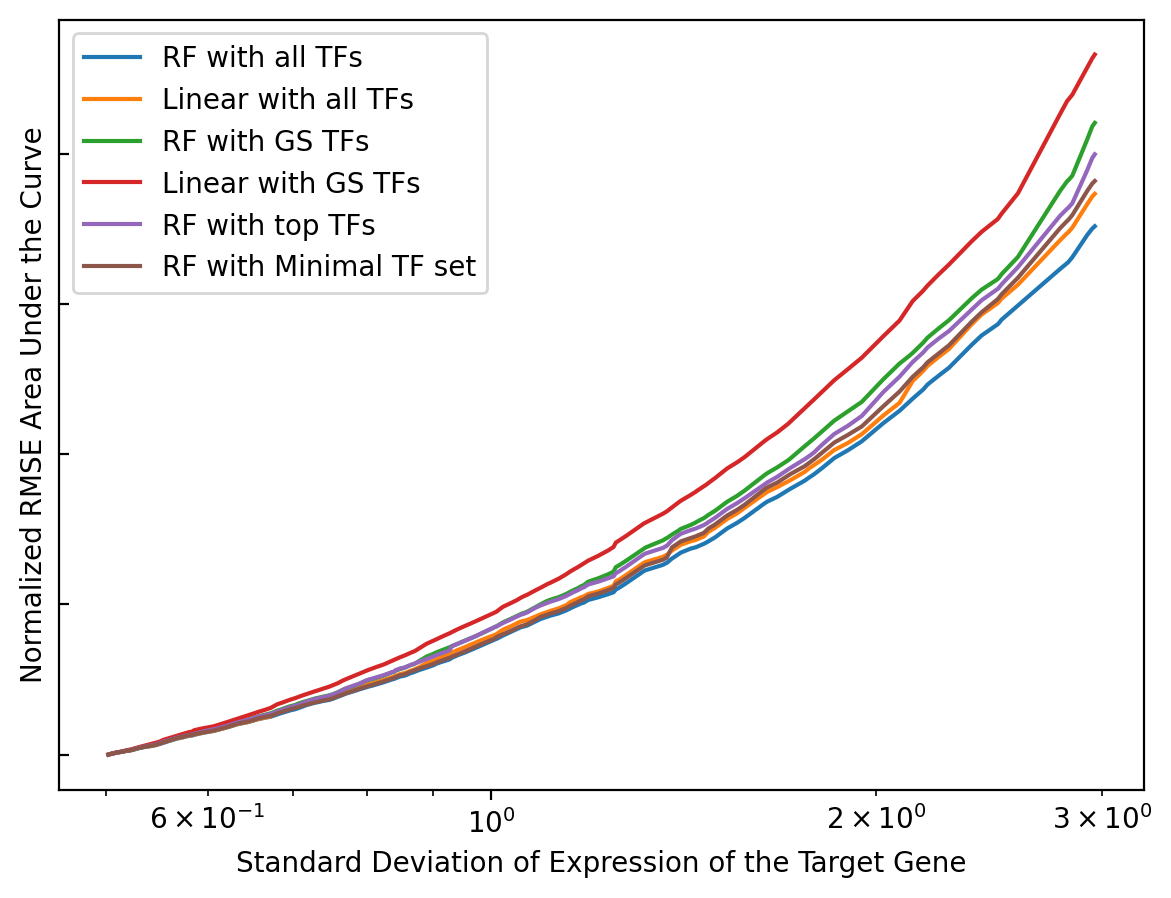

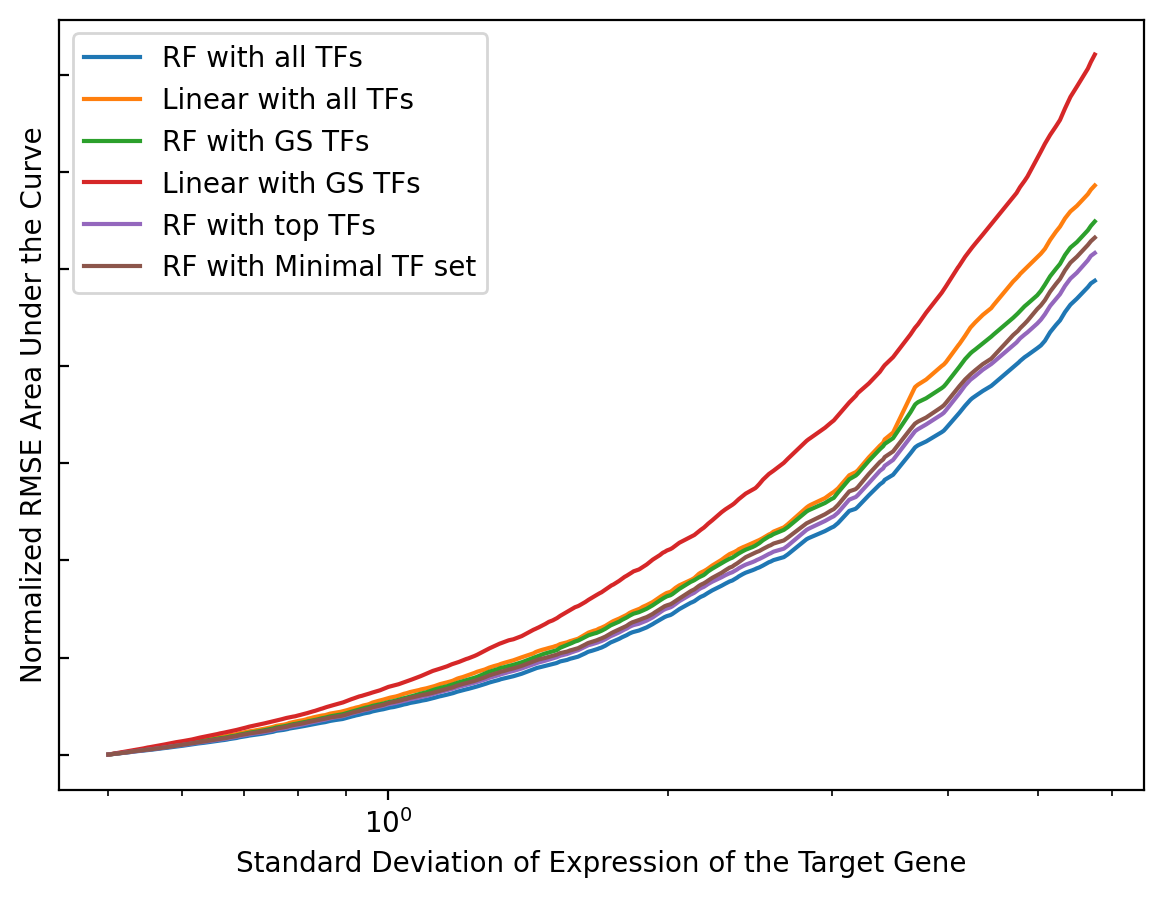

In [120]:
# AUPRC analogy
for df, species_name in zip(res_df_list, species_file_names):

    df = df.sort_values('test_std')
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xscale('log')
    df = df.sort_values('test_std').head(int(len(df)*(0.9)))
    x = df['test_std']

    for model, model_name in zip(compare_list, compare_name_list):
        y = df[model]
        y_norm = y/x
        auc = [np.trapz(y_norm[:i+1], x[:i+1]) for i in range(len(x))]
        ax.plot(x, auc, label=model_name)
    ax.set(xlabel='Standard Deviation of Expression of the Target Gene')
    ax.set(ylabel='Normalized RMSE Area Under the Curve')
    ax.tick_params(axis="y",direction="in", pad=-22, labelleft=False)
    # ax.tick_params(axis="x",direction="in", pad=-15)
    # plt.title('Model Performance on '+ species_name +' Target Genes')
    plt.legend(loc="best")
    # plt.show()
    plt.savefig('./plot_output/rmse_auc/'+species_name+'.pdf', bbox_inches='tight')

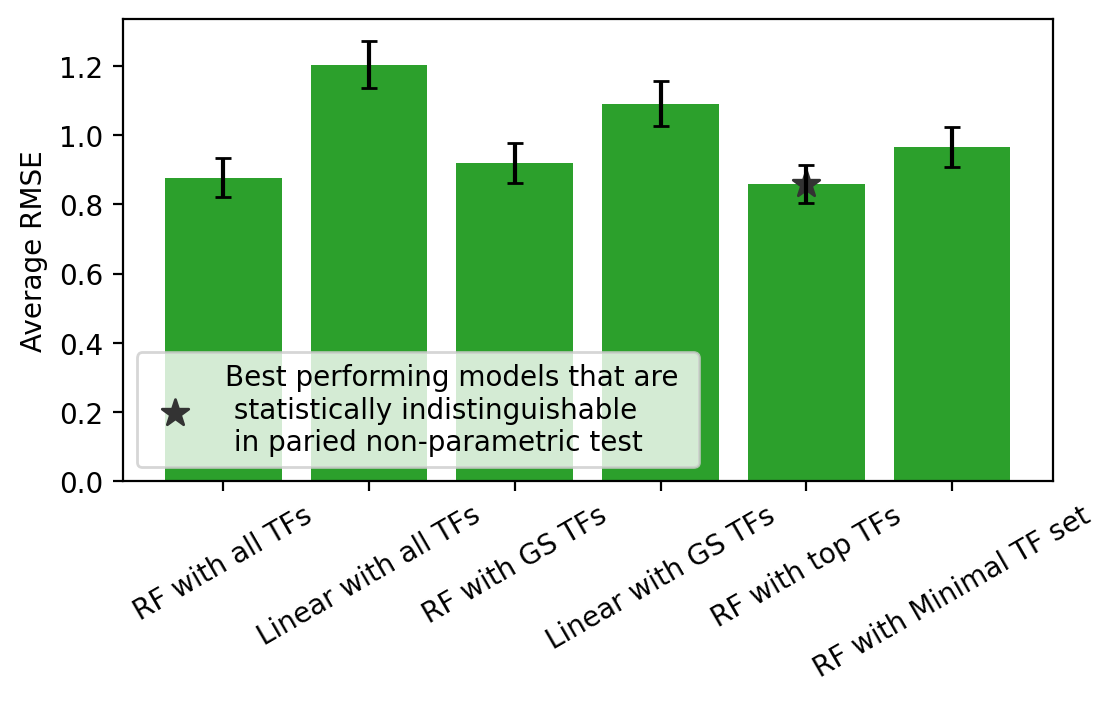

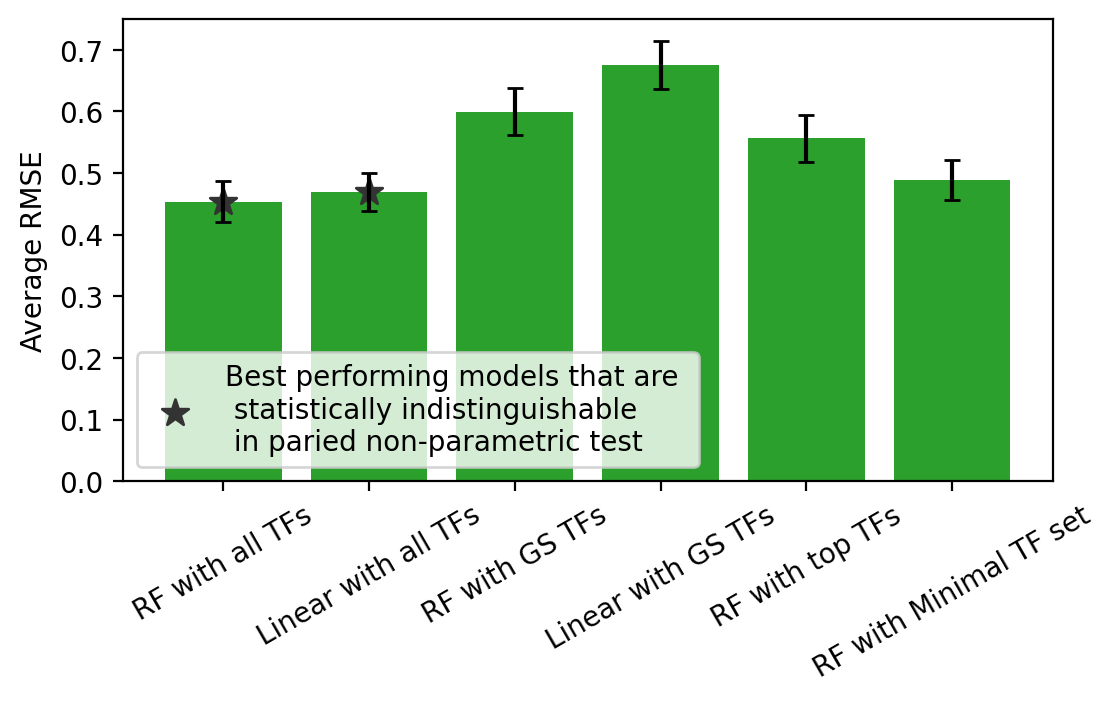

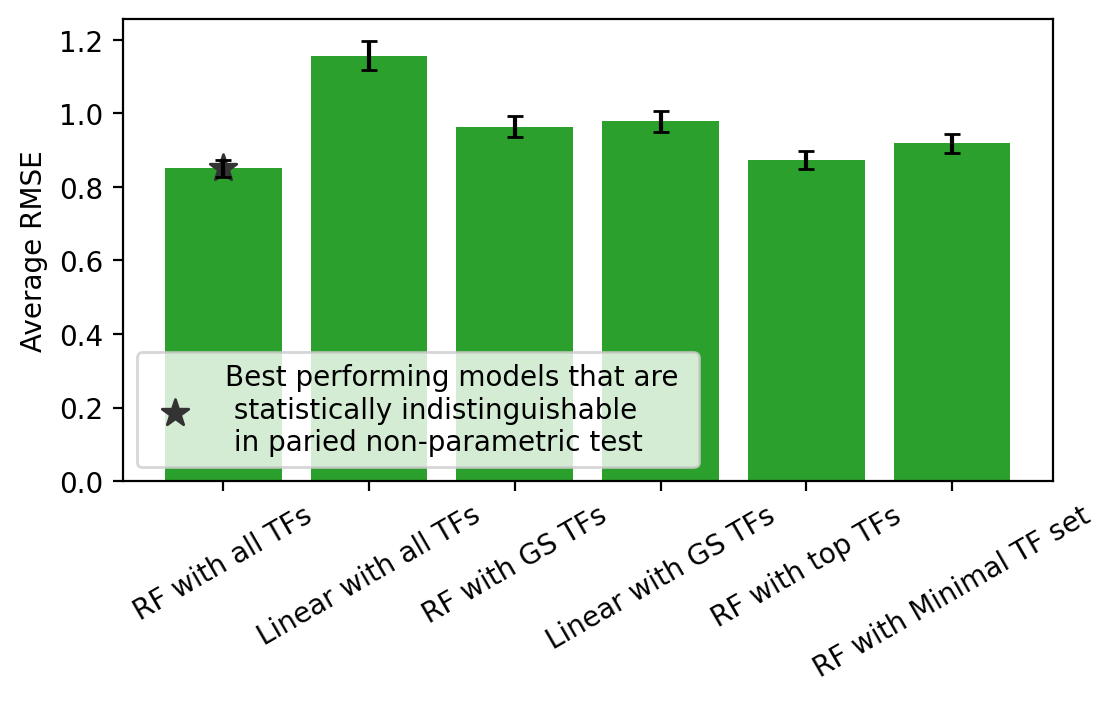

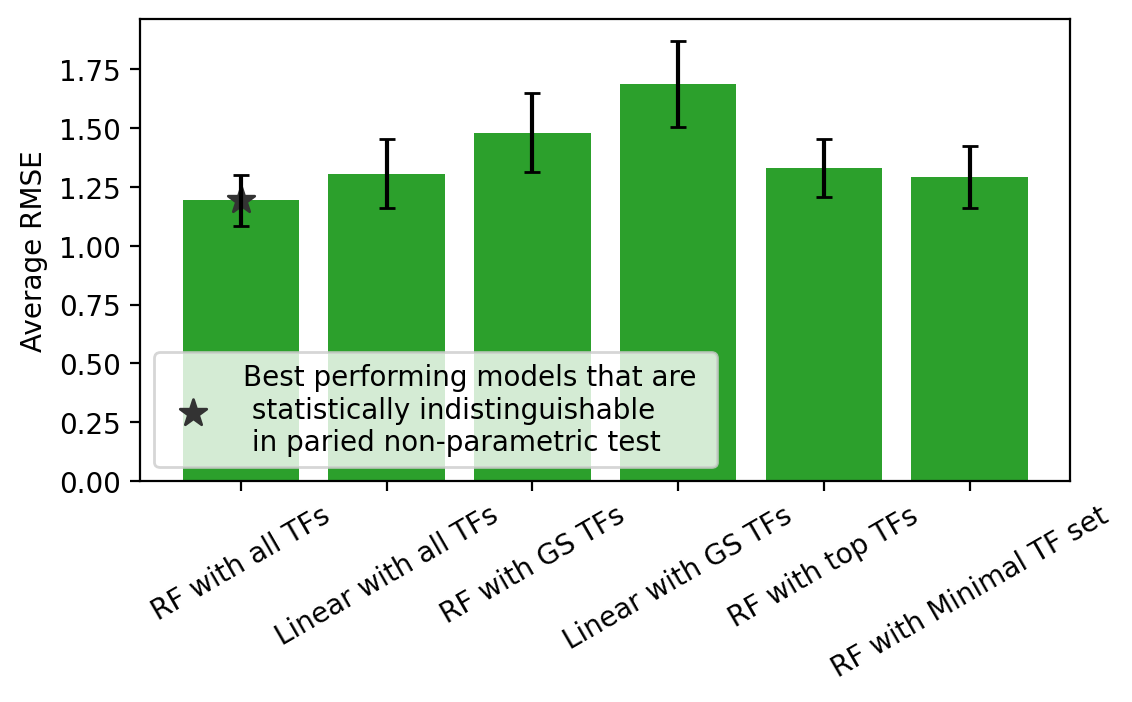

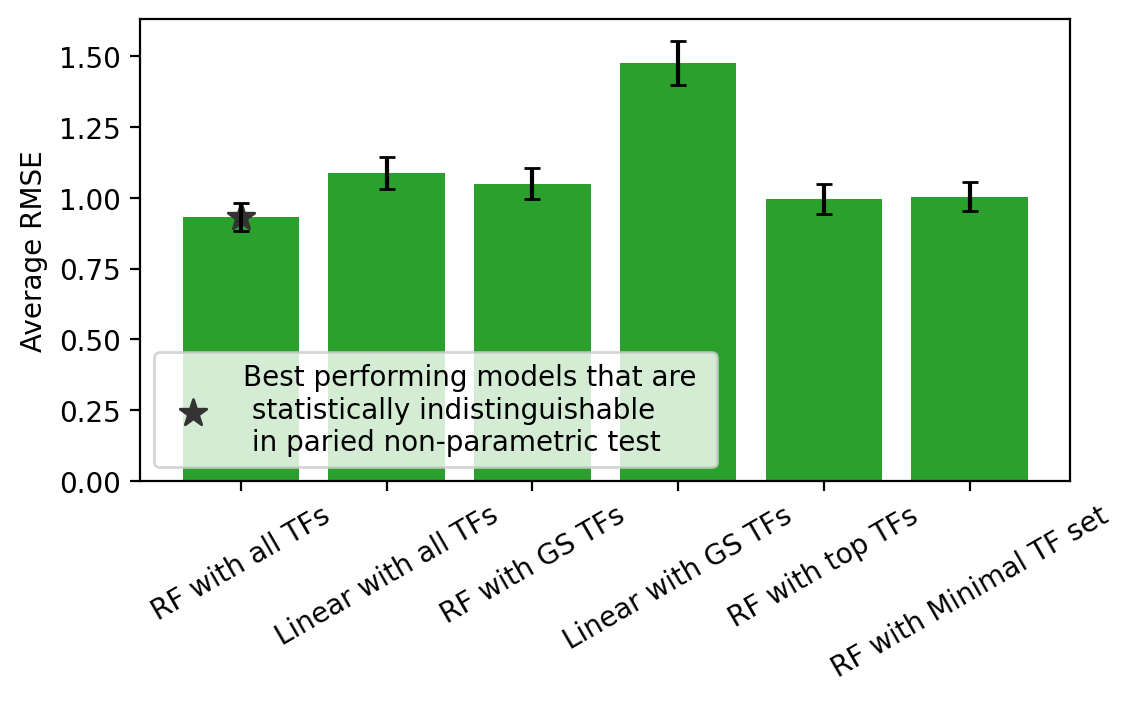

In [7]:
# RMSE comparision bar plot
best_models_list = [[4], [0, 1], [0], [0], [0]]
for df, species_name, best_models in zip(res_df_list, species_file_names, best_models_list):
    best_model_names = [compare_name_list[i] for i in best_models]
    best_model_rmse = [df[compare_list[i]].mean() for i in best_models]
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(1, 1, 1)
    for i in range(6):
        ax.bar(compare_name_list[i], df[compare_list[i]].mean(), color=colors[2], yerr=df[compare_list[i]].sem(), capsize=3)
    ax.scatter(best_model_names,best_model_rmse, marker='*', label='Best performing models that are \n statistically indistinguishable \n in paried non-parametric test', color="#333", s=100)
    # ax.set_xticklabels(compare_name_list)
    ax.set(ylabel='Average RMSE')
    plt.xticks(rotation=30)
    plt.legend()
    plt.savefig('./plot_output/rmse_bar/{}.pdf'.format(species_name), bbox_inches='tight')